# DNN Evaluation

In [1]:
channel = 'SL' # change this [DL or SL]

import os
import sys
from glob import glob
from math import sqrt
import random
import string
import yaml
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
#plt.style.use('ggplot')
from collections import defaultdict
#import ROOT
import copy
import tensorflow.keras
import tensorflow.saved_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.utils.vis_utils import plot_model                                                                                                                
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pickle import load

2022-10-30 18:10:29.782584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
############ plot function for input features ############
def plotinputfeatures(featuredict, df_list_sig, df_bkg, masspoints, tag=''):
    for feat in list(featuredict.keys()):
        feat_info = featuredict.get(feat)
        nbins  = feat_info[0]
        xlow   = feat_info[1]
        xhigh  = feat_info[2]
        nbins_ = np.linspace(xlow, xhigh, nbins)
        feat_bkg = df_bkg[feat].to_numpy()
        y_b,bins_b,patches_b = plt.hist(feat_bkg,nbins_,density=True,histtype='stepfilled',
                                        alpha=0.4,lw=2,log=False, label = 'Background')
        for i,df_sig in enumerate(df_list_sig):
            feat_sig = df_sig[feat].to_numpy()
            _,_,_ = plt.hist(feat_sig,nbins_,density=True,histtype='stepfilled',
                             alpha=0.3,lw=2,log=False, label = f'Signal_{masspoints[i]}')
    
        plt.xlabel(feat, fontsize=18)
        plt.ylabel('Normalised events', fontsize=18)
        plt.xticks(size = 18)
        plt.yticks(size = 18)
        plt.legend(loc='best', fontsize=16)
        plt.grid(True)
        
        plt.savefig(os.path.join(tagdir,feat+tag+'.png'), dpi=300)
        #plt.savefig(os.path.join(tagdir,feat+tag+'.pdf'), dpi=300)
        plt.show()
        plt.clf()

def prepare_df(basepath, filepath, treename, xsec, mass, masslist, clstag, features):
    treefile_   = os.path.join(basepath,filepath)
    if not os.path.isfile(treefile_):
        raise RuntimeError(f'{treefile_} does not exist')
    histfile_   = treefile_.replace('mvaIn','hist')
    histfile = uproot.open(histfile_)
    bincontents = histfile['evtCutFlow'].values()
    nEvProd  = bincontents[0]
    treefile = uproot.open(treefile_)
    #print(treefile.keys(), treename)
    tree = treefile[treename]
    for i, feat in enumerate(features):
        if i == 0:
            dfitem = tree[feat].array(library='pd')
        else:
            column_i = tree[feat].array(library='pd')
            dfitem = pd.concat([dfitem, column_i], axis=1)
    #print(df1.to_numpy())
    #dfitem   = tree.pandas.df(features)
    dfitem.columns = features
    dfitem['mass'] = np.random.choice(masslist, size=dfitem.shape[0]) if clstag == 0 else mass
    #if clstag == 0:
    #    dfitem['mass'] = np.random.choice(masslist, size=dfitem.shape[0])
    #else:
    #    dfitem['mass'] = mass
    dfitem['tag'] = clstag
    dfitem['wt'] = xsec/nEvProd
    print(f'cross-section: {xsec}\t nEvProd: {nEvProd}\t 1 lumi scaling wt: {xsec/nEvProd}')
    print(f'shape: {dfitem.shape}\t keys:{dfitem.keys()}')
    #print(dfitem)
    return dfitem

def signif_syst(S, B, syst):
    return S/sqrt(B + (0.01*syst*B)*(0.01*syst*B))

In [3]:
# Load config
### open config.yaml and get all the necessary parameters
with open(os.path.join('Yamls', f'config_{channel}.yaml'), 'r') as inf:
    config = yaml.safe_load(inf)
    
mainkeys    = list(config.keys())
tag         = config.get('Tag')
tagdir      = os.path.join(os.getcwd(),tag)

if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f'{tagdir} already exists ...')

lumi              = config.get('Lumi')    
maindir           = config.get('Basepath')
maintree          = config.get('Intree')
infiledict        = config.get('Infiles')
all_featuredict   = config.get('Features')
train_featuredict = all_featuredict.get('Variables')
print(f'Train_FeatureDict: {train_featuredict}')
spect_featuredict = all_featuredict.get('Spectators')
print(f'Spectator_FeatureDict: {spect_featuredict}')
featuredict       = {**train_featuredict, **spect_featuredict}
print(f'FeatureDict: {featuredict}')
featurelist       = list(featuredict.keys())
print(f'all feature list : {featurelist}')
signaldict        = infiledict.get('Signal')
backgrounddict    = infiledict.get('Background')
masspoints        = config.get('Mass')
scale             = config.get('DoScaling')
#dotrain        = config.get('DoTrain')

modelparamdict = config.get('ModelParams')
LayerDims      = modelparamdict.get('Layers')
IsBatchNorm    = modelparamdict.get('BatchNorms')
DropOuts       = modelparamdict.get('Dropout')
L2regs         = modelparamdict.get('L2')
Activations    = modelparamdict.get('activ')

trainingparamdict = config.get('TrainingParams')
LossFunc = trainingparamdict.get('Loss')
LRate    = trainingparamdict.get('LR')
print(f'Learning rate : {LRate}')
Metrics  = trainingparamdict.get('Metrics')
valSplit = trainingparamdict.get('valSplit')
nEpoch   = trainingparamdict.get('epoch') 
opt      = tensorflow.keras.optimizers.Adam(learning_rate=LRate)
batchsize = trainingparamdict.get('BatchSize')
print(f'Batch size : {batchsize}')

# Prepare train-test datasets (panda df)
### Use root_panda to get the event info from root files

##################################################################
##################################################################
signal_info_list     = list(signaldict.values())
background_info_list = list(backgrounddict.values())

print(signaldict)
print(backgrounddict)

dfs_signal     = []
dfs_background = []

print('preparing signal dataframes ...')
for idx, (key, val) in enumerate(signaldict.items()):
    print(f'process: {key}')
    proc = key
    filepath = val[0]
    xsec     = val[1]
    mass     = masspoints[idx]
    clstag   = 1
    dfitem = prepare_df(maindir, filepath, maintree, xsec, mass, masspoints, 
                        clstag, list(train_featuredict.keys()))
    #print(dfitem)
    dfs_signal.append([proc, dfitem])
    
print('preparing background dataframes ...')
for key, val in backgrounddict.items():
    print(f'process: {key}')
    proc = key
    filepath = val[0]
    xsec     = val[1]
    mass     = random.choice(masspoints)
    clstag   = 0
    dfitem = prepare_df(maindir, filepath, maintree, xsec, mass, masspoints, 
                        clstag, list(train_featuredict.keys()))
    dfs_background.append([proc, dfitem])

    
    
dfs_comb = dfs_signal + dfs_background
print(dfs_comb)

# Keep the variables only. Drop the spectators
#df_total_sig2 = df_total_sig.drop(list(spect_featuredict.keys()), axis=1)
#df_sig = np.concatenate((x_train_scaled, x_train[:,-1].reshape(x_train.shape[0],1)), axis=1)
#df_total_bkg2 = df_total_bkg.drop(list(spect_featuredict.keys()), axis=1)

/home/gsaha/Work/DelphesML/ColOctet/DNN/SL_pNN already exists ...
Train_FeatureDict: {'pt_bjet1': [100, 0.0, 800.0], 'pt_bjet2': [50, 0.0, 400.0], 'eta_bjet1': [25, 0.0, 5], 'eta_bjet2': [25, 0.0, 5], 'met': [50, 0.0, 200.0], 'pt_tauh': [50, 0.0, 200.0], 'eta_tauh': [25, 0.0, 5], 'pt_lep': [50, 0.0, 200.0], 'eta_lep': [25, 0.0, 5], 'dr_lep_tauh': [25, 0.0, 5], 'dphi_lep_met': [32, 0.0, 3.2], 'dphi_tauh_met': [32, 0.0, 3.2], 'pt_h3': [50, 0.0, 400.0], 'dr_lep_h3': [25, 0.0, 5], 'dr_tauh_h3': [25, 0.0, 5], 'dr_lep_tauh_x_pt_h3': [60, 0.0, 600.0], 'dr_bjet1_bjet2': [25, 0.0, 5], 'pt_ss2': [60, 0.0, 600.0], 'dr_bjet1_ss2': [25, 0.0, 5], 'dr_bjet2_ss2': [25, 0.0, 5], 'dr_bjet1_bjet2_x_pt_ss2': [100, 0, 1500], 'dr_lep_bjet1': [25, 0.0, 5], 'dr_lep_bjet2': [25, 0.0, 5], 'dr_tauh_bjet1': [25, 0.0, 5], 'dr_tauh_bjet2': [25, 0.0, 5], 'dphi_bjet1_met': [32, 0.0, 3.2], 'dphi_bjet2_met': [32, 0.0, 3.2], 'dr_bjet1_h3': [25, 0.0, 5], 'dr_bjet2_h3': [25, 0.0, 5], 'dr_lep_ss2': [25, 0.0, 5], 'dr_tauh_s

cross-section: 0.05	 nEvProd: 1250000.0	 1 lumi scaling wt: 4e-08
shape: (50234, 42)	 keys:Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'mass', 'tag',
       'wt'],
      dtype='object')
process: M_147
cross-section: 0.05	 nEvProd: 1250000.0	 1 lumi scaling wt: 4e-08
shape: (55454, 42)	 keys:Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_

cross-section: 0.2086	 nEvProd: 4250000.0	 1 lumi scaling wt: 4.908235294117647e-08
shape: (34198, 42)	 keys:Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'mass', 'tag',
       'wt'],
      dtype='object')
process: ZhTo2b2tau
cross-section: 0.022	 nEvProd: 5900000.0	 1 lumi scaling wt: 3.7288135593220335e-09
shape: (87800, 42)	 keys:Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       

In [4]:
scaler = load(open(os.path.join(tagdir,'scaler.pkl'), 'rb'))
json_file  = open(os.path.join(tagdir,"DNN_model_resnet.json"), 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model                                                                                                                             
model.load_weights(os.path.join(tagdir,"DNN_model_resnet.h5"))

#model = tensorflow.keras.models.load_model(os.path.join(tagdir,"DNN_model.h5"))
print("Loaded model from disk")

2022-10-30 18:10:37.893541: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-30 18:10:37.895076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-30 18:10:37.901718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-30 18:10:37.901752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-30 18:10:37.904612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-30 18:10:37.904666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Loaded model from disk


Starting to predict
Process : M_66
(32588, 42)


2022-10-30 18:10:39.516988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-30 18:10:39.517530: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-10-30 18:10:39.912143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Process : M_75
(36356, 42)
Process : M_88
(37803, 42)
Process : M_100
(44571, 42)
Process : M_121
(50234, 42)
Process : M_147
(55454, 42)
Process : TTJets2L
(431463, 42)
Process : TTJets1L
(67823, 42)
Process : TTWJetsLNu
(48177, 42)
Process : TTWToQQ
(28837, 42)
Process : TTZJetsLL
(46498, 42)
Process : TTZToQQ
(49983, 42)
Process : TTH
(174536, 42)
Process : WZTo3LNu
(1134, 42)
Process : WZTo2L2Q
(651, 42)
Process : ZZTo4L
(206, 42)
Process : ZZTo2b2tau
(34198, 42)
Process : ZhTo2b2tau
(87800, 42)
Process : bbtata
(44331, 42)
Process : TW2L
(328512, 42)
Process : WWW
(36, 42)
Process : WWZ
(126, 42)
Process : WZZ
(112, 42)
Process : ZZZ
(162, 42)


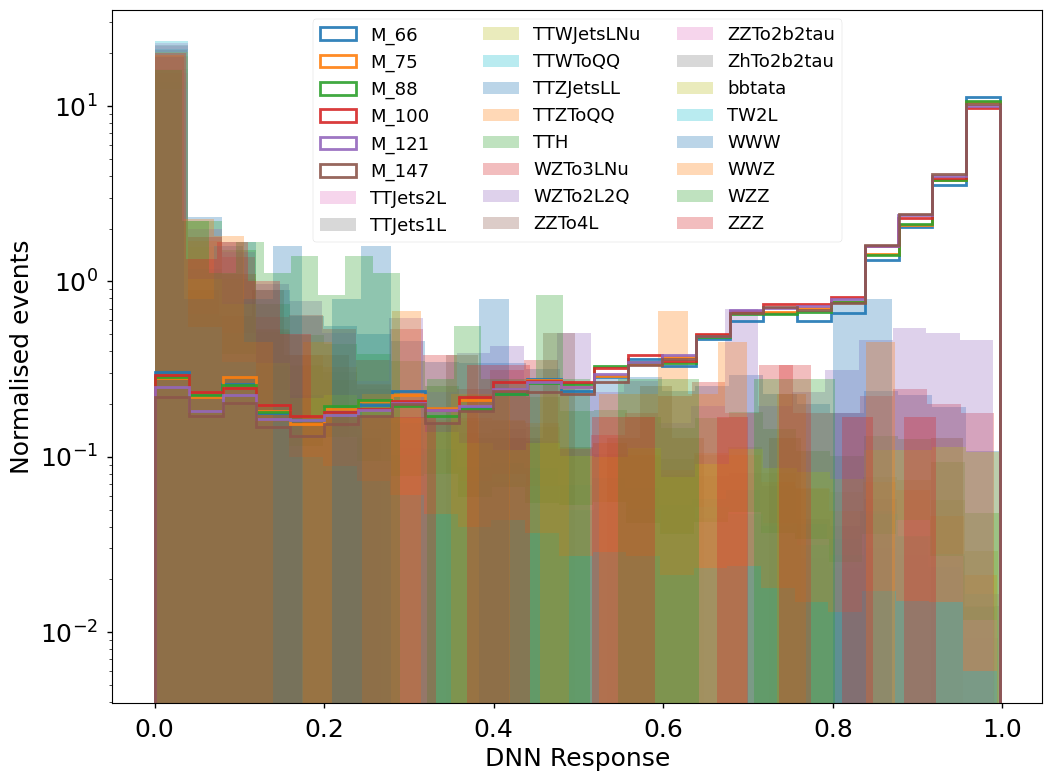

Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'mass', 'tag',
       'wt', 'score'],
      dtype='object') -> (1601591, 43)


In [5]:
print('Starting to predict')
keysToKeep = list(train_featuredict.keys()) + ['mass']
plt.figure(figsize=(12,9))
df_list = []
for proc, df in dfs_comb:
    print(f'Process : {proc}')
    #featarray = df.to_numpy()
    featarr = df[keysToKeep].to_numpy()
    print(df.shape)
    #print(featarr.shape)
    #massarr = df['mass'].to_numpy()
    x_test  = scaler.transform(featarr) if scale else featarr
    #x_test  = np.concatenate((x_feat, massarr.reshape(df.shape[0],1)), axis=1)
    #print(x_test[:2,:])
    score = model.predict(x_test)
    #prediction = score[:,:-1].flatten()
    prediction = score[:,-1].reshape(df.shape[0],1)
    #print(prediction.shape)
    df_temp = pd.concat([df, pd.DataFrame(prediction, columns=['score'])], axis=1)
    df_list.append(df_temp)
    #print(df_done)
    if 'M' in proc:
        plt.hist(prediction.flatten(), bins=25, density=True, histtype='step', 
                 alpha=0.9, lw=2, label=proc, log=True)
    else:
        plt.hist(prediction.flatten(), bins=25, density=True, histtype='bar', 
                 alpha=0.3, lw=2, label=proc, log=True)

plt.xlabel('DNN Response', fontsize=18)
plt.ylabel('Normalised events', fontsize=18)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.legend(loc='upper center', fontsize=13, ncol=3)
plt.savefig(os.path.join(tagdir, 'Normalised_DNN_Scores.pdf'), dpi=300)
plt.savefig(os.path.join(tagdir, 'Normalised_DNN_Scores.png'), dpi=300)

plt.show()

df_done = pd.concat(df_list)
print(f'{df_done.keys()} -> {df_done.shape}')

df_done.to_hdf(os.path.join(tagdir,'dataframe_with_prediction.h5'), key='df') 

### Read the dataframe with prediction from saved h5 file

In [6]:
h5_file = os.path.join(tagdir, 'dataframe_with_prediction.h5')
df_comb = pd.read_hdf(h5_file, "df")
print(f'Combined dataframe: keys -> {df_comb.keys()}\t shape -> {df_comb.shape}')
print(df_comb)

Combined dataframe: keys -> Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'mass', 'tag',
       'wt', 'score'],
      dtype='object')	 shape -> (1601591, 43)
       pt_bjet1    pt_bjet2  eta_bjet1  eta_bjet2         met    pt_tauh  \
0    528.873047  195.789551   1.049471   0.692358  194.011642  38.423752   
1    113.005821   60.444019   1.190275   2.290817  137.879837  92.651299   
2    106.583107   49.373074   0

In [7]:
# Separate signal and bkg dataframes
df_sig = df_comb[df_comb['tag'] == 1]
df_bkg = df_comb[df_comb['tag'] == 0]

print(df_sig)
print(df_bkg)

from math import sqrt
nEv_bkg_total = lumi * df_bkg['wt'].sum()
for mass in masspoints:
    print(f'Mass : {mass}')
    df_sig_2 = df_sig[df_sig['mass'] == mass]
    print(df_sig_2.shape)
    max_signif = 0.0
    best_sigeff = 0.0
    best_bkgeff = 0.0
    nEv_sig_total = lumi * df_sig_2['wt'].sum()
    for sc in np.linspace(0,1,100):
        #print(f'Score: {sc}')
        nEv_sig = lumi * df_sig_2.loc[df_sig_2["score"] >= sc, "wt"].sum()
        #print(f'nEv sig: {nEv_sig}')
        nEv_bkg  = lumi * df_bkg.loc[df_bkg['score'] >= sc, 'wt'].sum()
        #print(f'nEv bkg: {nEv_bkg}')
        signif = nEv_sig/sqrt(nEv_bkg) if nEv_bkg > 0 else 0
        #print(f'significance: {signif}')
        sig_eff = nEv_sig/nEv_sig_total
        bkg_eff = nEv_bkg/nEv_bkg_total
        if signif > max_signif:
            max_signif = signif
            best_sigeff = sig_eff
            best_bkgeff = bkg_eff
    print(f'Max Significance: {max_signif}')
    print(f'nSig : {best_sigeff*nEv_sig_total}\t efficiency: {best_sigeff}')
    print(f'nBkg : {best_bkgeff*nEv_bkg_total}\t efficiency: {best_bkgeff}')
    print(f'Max Significance with 10% syst: {signif_syst(best_sigeff*nEv_sig_total, best_bkgeff*nEv_bkg_total, 10)}\n')

         pt_bjet1    pt_bjet2  eta_bjet1  eta_bjet2         met     pt_tauh  \
0      528.873047  195.789551   1.049471   0.692358  194.011642   38.423752   
1      113.005821   60.444019   1.190275   2.290817  137.879837   92.651299   
2      106.583107   49.373074   0.369735   1.047883   42.275177   66.702591   
3      743.552307  142.102966   0.238088   0.641982  194.371658   26.188702   
4      254.540909  184.290054   0.264632   1.576241  107.255264   27.698576   
...           ...         ...        ...        ...         ...         ...   
55449  144.414047  129.692230   0.636575   2.263535   38.499260   41.185047   
55450  341.148071  296.994812   1.196666   0.142128   79.087242   52.131817   
55451  218.956665  141.832809   0.286325   1.982371   77.253136   50.309410   
55452  371.896759  270.886383   0.525458   0.618922   41.057640   25.677465   
55453  327.944519  304.535309   0.193761   0.338133  117.114136  100.202248   

       eta_tauh      pt_lep   eta_lep  dr_lep_tauh 